# 8. Signal Processing
https://docs.scipy.org/doc/scipy/reference/tutorial/index.html   
https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The signal processing toolbox currently contains some filtering functions, a limited set of filter design tools, and a few B-spline interpolation algorithms for one- and two-dimensional data. While the B-spline algorithms could technically be placed under the interpolation category, they are included here because they only work with equally-spaced data and make heavy use of filter-theory and transfer-function formalism to provide a fast B-spline transform. To understand this section you will need to understand that a signal in SciPy is an array of real or complex numbers.

## B-splines
A B-spline is an approximation of a continuous function over a finite- domain in terms of B-spline coefficients and knot points. If the knot- points are equally spaced with spacing Δx , then the B-spline approximation to a 1-dimensional function is the finite-basis expansion.
> $y\left(x\right)\approx\sum_{j}c_{j}\beta^{o}\left(\frac{x}{\Delta x}-j\right).$

In two dimensions with knot-spacing Δx and Δy , the function representation is
> $z\left(x,y\right)\approx\sum_{j}\sum_{k}c_{jk}\beta^{o}\left(\frac{x}{\Delta x}-j\right)\beta^{o}\left(\frac{y}{\Delta y}-k\right).$

In these expressions, βo(⋅) is the space-limited B-spline basis function of order, o . The requirement of equally-spaced knot-points and equally-spaced data points, allows the development of fast (inverse-filtering) algorithms for determining the coefficients, cj , from sample-values, yn . Unlike the general spline interpolation algorithms, these algorithms can quickly find the spline coefficients for large images.

The advantage of representing a set of samples via B-spline basis functions is that continuous-domain operators (derivatives, re- sampling, integral, etc.) which assume that the data samples are drawn from an underlying continuous function can be computed with relative ease from the spline coefficients. For example, the second-derivative of a spline is
> $y{}^{\prime\prime}\left(x\right)=\frac{1}{\Delta x^{2}}\sum_{j}c_{j}\beta^{o\prime\prime}\left(\frac{x}{\Delta x}-j\right).$

Using the property of B-splines that
> $\frac{d^{2}\beta^{o}\left(w\right)}{dw^{2}}=\beta^{o-2}\left(w+1\right)-2\beta^{o-2}\left(w\right)+\beta^{o-2}\left(w-1\right)$

it can be seen that
> $y^{\prime\prime}\left(x\right)=\frac{1}{\Delta x^{2}}\sum_{j}c_{j}\left[\beta^{o-2}\left(\frac{x}{\Delta x}-j+1\right)-2\beta^{o-2}\left(\frac{x}{\Delta x}-j\right)+\beta^{o-2}\left(\frac{x}{\Delta x}-j-1\right)\right].$

If o=3 , then at the sample points,
> $\begin{eqnarray*} \Delta x^{2}\left.y^{\prime}\left(x\right)\right|_{x=n\Delta x} & = & \sum_{j}c_{j}\delta_{n-j+1}-2c_{j}\delta_{n-j}+c_{j}\delta_{n-j-1},\\  & = & c_{n+1}-2c_{n}+c_{n-1}.\end{eqnarray*}$

Thus, the second-derivative signal can be easily calculated from the spline fit. if desired, smoothing splines can be found to make the second-derivative less sensitive to random-errors.

The savvy reader will have already noticed that the data samples are related to the knot coefficients via a convolution operator, so that simple convolution with the sampled B-spline function recovers the original data from the spline coefficients. The output of convolutions can change depending on how boundaries are handled (this becomes increasingly more important as the number of dimensions in the data- set increases). The algorithms relating to B-splines in the signal- processing sub package assume mirror-symmetric boundary conditions. Thus, spline coefficients are computed based on that assumption, and data-samples can be recovered exactly from the spline coefficients by assuming them to be mirror-symmetric also.

Currently the package provides functions for determining second- and third- order cubic spline coefficients from equally spaced samples in one- and two- dimensions ***(qspline1d, qspline2d, cspline1d, cspline2d)***. The package also supplies a function ***( bspline )*** for evaluating the bspline basis function, βo(x) for arbitrary order and x. For large o , the B-spline basis function can be approximated well by a zero-mean Gaussian function with standard-deviation equal to$\sigma_{o}=\left(o+1\right)/12$ :
> $\beta^{o}\left(x\right)\approx\frac{1}{\sqrt{2\pi\sigma_{o}^{2}}}\exp\left(-\frac{x^{2}}{2\sigma_{o}}\right).$

A function to compute this Gaussian for arbitrary x and o is also available ( ***gauss_spline*** ). The following code and Figure uses spline-filtering to compute an edge-image (the second-derivative of a smoothed spline) of a raccoon’s face which is an array returned by the command ***misc.face***. The command ***sepfir2d*** was used to apply a separable two-dimensional FIR filter with mirror- symmetric boundary conditions to the spline coefficients. This function is ideally suited for reconstructing samples from spline coefficients and is faster than convolve2d which convolves arbitrary two-dimensional filters and allows for choosing mirror-symmetric boundary conditions.

In [2]:
import numpy as np
from scipy import signal, misc
import matplotlib.pyplot as plt

image = misc.face(gray=True).astype(np.float32)
derfilt = np.array([1.0, -2, 1.0], dtype=np.float32)
ck = signal.cspline2d(image, 8.0)
deriv = (signal.sepfir2d(ck, derfilt, [1]) +
         signal.sepfir2d(ck, [1], derfilt))

Alternatively we could have done:
```
laplacian = np.array([[0,1,0], [1,-4,1], [0,1,0]], dtype=np.float32)
deriv2 = signal.convolve2d(ck,laplacian,mode='same',boundary='symm')
```

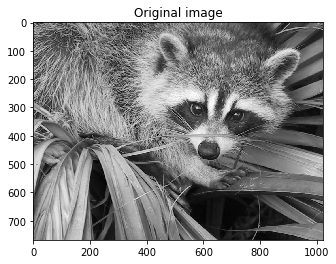

In [3]:
plt.figure()
plt.imshow(image)
plt.gray()
plt.title('Original image')
plt.show()

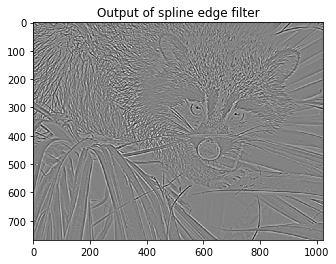

In [5]:
plt.figure()
plt.imshow(deriv)
plt.gray()
plt.title('Output of spline edge filter')
plt.show()

## Filtering
Filtering is a generic name for any system that modifies an input signal in some way. In SciPy a signal can be thought of as a Numpy array. There are different kinds of filters for different kinds of operations. There are two broad kinds of filtering operations: linear and non-linear. ***Linear filters*** can always be reduced to multiplication of the flattened Numpy array by an appropriate matrix resulting in another flattened Numpy array. Of course, this is not usually the best way to compute the filter as the matrices and vectors involved may be huge. For example filtering a 512×512 image with this method would require multiplication of a $512^2$×$512^2$ matrix with a $512^2$ vector. Just trying to store the  $512^2$×$512^2$ matrix using a standard Numpy array would require 68,719,476,736 elements. At 4 bytes per element this would require 256GB of memory. In most applications most of the elements of this matrix are zero and a different method for computing the output of the filter is employed.

### Convolution/Correlation

Many linear filters also have the property of ***shift-invariance***. This means that the filtering operation is the same at different locations in the signal and it implies that the filtering matrix can be constructed from knowledge of one row (or column) of the matrix alone. In this case, the matrix multiplication can be accomplished using Fourier transforms.

Let x[n] define a one-dimensional signal indexed by the integer n.n. Full convolution of two one-dimensional signals can be expressed as
> $y\left[n\right]=\sum_{k=-\infty}^{\infty}x\left[k\right]h\left[n-k\right].$

This equation can only be implemented directly if we limit the sequences to finite support sequences that can be stored in a computer, choose n=0 to be the starting point of both sequences, let K+1 be that value for which y[n]=0 for all n>K+1 and M+1 be that value for which x[n]=0 for all n>M+1 , then the discrete convolution expression is
> $y\left[n\right]=\sum_{k=\max\left(n-M,0\right)}^{\min\left(n,K\right)}x\left[k\right]h\left[n-k\right].$

For convenience assume K≥M. Then, more explicitly the output of this operation is
> $\begin{eqnarray*} y\left[0\right] & = & x\left[0\right]h\left[0\right]\\ y\left[1\right] & = & x\left[0\right]h\left[1\right]+x\left[1\right]h\left[0\right]\\ y\left[2\right] & = & x\left[0\right]h\left[2\right]+x\left[1\right]h\left[1\right]+x\left[2\right]h\left[0\right]\\ \vdots & \vdots & \vdots\\ y\left[M\right] & = & x\left[0\right]h\left[M\right]+x\left[1\right]h\left[M-1\right]+\cdots+x\left[M\right]h\left[0\right]\\ y\left[M+1\right] & = & x\left[1\right]h\left[M\right]+x\left[2\right]h\left[M-1\right]+\cdots+x\left[M+1\right]h\left[0\right]\\ \vdots & \vdots & \vdots\\ y\left[K\right] & = & x\left[K-M\right]h\left[M\right]+\cdots+x\left[K\right]h\left[0\right]\\ y\left[K+1\right] & = & x\left[K+1-M\right]h\left[M\right]+\cdots+x\left[K\right]h\left[1\right]\\ \vdots & \vdots & \vdots\\ y\left[K+M-1\right] & = & x\left[K-1\right]h\left[M\right]+x\left[K\right]h\left[M-1\right]\\ y\left[K+M\right] & = & x\left[K\right]h\left[M\right].\end{eqnarray*}$

Thus, the full discrete convolution of two finite sequences of lengths K+1 and M+1 respectively results in a finite sequence of length$K+M+1=\left(K+1\right)+\left(M+1\right)-1.$

One dimensional convolution is implemented in SciPy with the function ***convolve***. This function takes as inputs the signals x, h , and two optional flags ‘mode’ and ‘method’ and returns the signal y.

The first optional flag ‘mode’ allows for specification of which part of the output signal to return. The default value of ‘full’ returns the entire signal. If the flag has a value of ‘same’ then only the middle KK values are returned starting at y[⌊M−12⌋] so that the output has the same length as the first input. If the flag has a value of ‘valid’ then only the middle K−M+1=(K+1)−(M+1)+1 output values are returned where z depends on all of the values of the smallest input from h[0] to h[M]. In other words only the values y[M] to y[K] inclusive are returned.

The second optional flag ‘method’ determines how the convolution is computed, either through the Fourier transform approach with fftconvolve or through the direct method. By default, it selects the expected faster method. The Fourier transform method has order O(NlogN) while the direct method has order O(N2). Depending on the big O constant and the value of NN, one of these two methods may be faster. The default value ‘auto’ performs a rough calculation and chooses the expected faster method, while the values ‘direct’ and ‘fft’ force computation with the other two methods.

The code below shows a simple example for convolution of 2 sequences

In [7]:
x = np.array([1.0, 2.0, 3.0])
h = np.array([0.0, 1.0, 0.0, 0.0, 0.0])
signal.convolve(x, h)

array([ 0.,  1.,  2.,  3.,  0.,  0.,  0.])

In [8]:
signal.convolve(x, h, 'same')

array([ 2.,  3.,  0.])

This same function convolve can actually take NN -dimensional arrays as inputs and will return the NN -dimensional convolution of the two arrays as is shown in the code example below. The same input flags are available for that case as well.

In [9]:
x = np.array([[1., 1., 0., 0.], [1., 1., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.]])
h = np.array([[1., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 0.]])
signal.convolve(x, h)

array([[ 1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Correlation is very similar to convolution except for the minus sign becomes a plus sign. Thus
> $w\left[n\right]=\sum_{k=-\infty}^{\infty}y\left[k\right]x\left[n+k\right]$

is the (cross) correlation of the signals yy and x.x. For finite-length signals with y[n]=0 outside of the range [0,K] and x[n]=0 outside of the range [0,M], the summation can simplify to
> $w\left[n\right]=\sum_{k=\max\left(0,-n\right)}^{\min\left(K,M-n\right)}y\left[k\right]x\left[n+k\right].$

Assuming again that K≥M this is
> $\begin{eqnarray*} w\left[-K\right] & = & y\left[K\right]x\left[0\right]\\ w\left[-K+1\right] & = & y\left[K-1\right]x\left[0\right]+y\left[K\right]x\left[1\right]\\ \vdots & \vdots & \vdots\\ w\left[M-K\right] & = & y\left[K-M\right]x\left[0\right]+y\left[K-M+1\right]x\left[1\right]+\cdots+y\left[K\right]x\left[M\right]\\ w\left[M-K+1\right] & = & y\left[K-M-1\right]x\left[0\right]+\cdots+y\left[K-1\right]x\left[M\right]\\ \vdots & \vdots & \vdots\\ w\left[-1\right] & = & y\left[1\right]x\left[0\right]+y\left[2\right]x\left[1\right]+\cdots+y\left[M+1\right]x\left[M\right]\\ w\left[0\right] & = & y\left[0\right]x\left[0\right]+y\left[1\right]x\left[1\right]+\cdots+y\left[M\right]x\left[M\right]\\ w\left[1\right] & = & y\left[0\right]x\left[1\right]+y\left[1\right]x\left[2\right]+\cdots+y\left[M-1\right]x\left[M\right]\\ w\left[2\right] & = & y\left[0\right]x\left[2\right]+y\left[1\right]x\left[3\right]+\cdots+y\left[M-2\right]x\left[M\right]\\ \vdots & \vdots & \vdots\\ w\left[M-1\right] & = & y\left[0\right]x\left[M-1\right]+y\left[1\right]x\left[M\right]\\ w\left[M\right] & = & y\left[0\right]x\left[M\right].\end{eqnarray*}$

The SciPy function correlate implements this operation. Equivalent flags are available for this operation to return the full K+M+1 length sequence (‘full’) or a sequence with the same size as the largest sequence starting at $w\left[-K+\left\lfloor \frac{M-1}{2}\right\rfloor \right]$ (‘same’) or a sequence where the values depend on all the values of the smallest sequence (‘valid’). This final option returns the K−M+1 values w[M−K] to w[0] inclusive.

The function correlate can also take arbitrary NN -dimensional arrays as input and return the NN -dimensional convolution of the two arrays on output.

When N=2,N=2, correlate and/or convolve can be used to construct arbitrary image filters to perform actions such as blurring, enhancing, and edge-detection for an image.

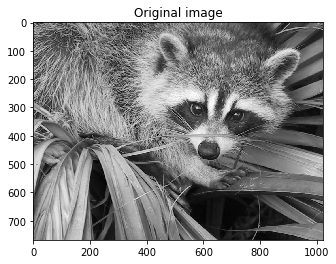

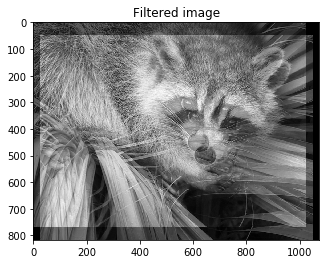

In [11]:
import numpy as np
from scipy import signal, misc
import matplotlib.pyplot as plt

image = misc.face(gray=True)
w = np.zeros((50, 50))
w[0][0] = 1.0
w[49][25] = 1.0
image_new = signal.fftconvolve(image, w)

plt.figure()
plt.imshow(image)
plt.gray()
plt.title('Original image')
plt.show()

plt.figure()
plt.imshow(image_new)
plt.gray()
plt.title('Filtered image')
plt.show()

Calculating the convolution in the time domain as above is mainly used for filtering when one of the signals is much smaller than the other ( K≫M ), otherwise linear filtering is more efficiently calculated in the frequency domain provided by the function fftconvolve. By default, convolve estimates the fastest method using choose_conv_method.

If the filter function w[n,m]w[n,m] can be factored according to
> $h[n, m] = h_1[n] h_2[m],$

convolution can be calculated by means of the function sepfir2d. As an example we consider a Gaussian filter gaussian
> $h[n, m] \propto e^{-x^2-y^2} = e^{-x^2} e^{-y^2}$

which is often used for blurring.

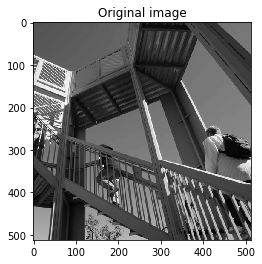

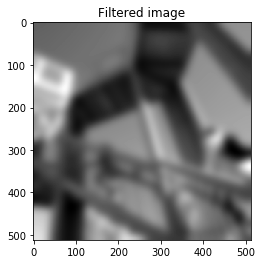

In [12]:
import numpy as np
from scipy import signal, misc
import matplotlib.pyplot as plt

image = misc.ascent()
w = signal.gaussian(50, 10.0)
image_new = signal.sepfir2d(image, w, w)

plt.figure()
plt.imshow(image)
plt.gray()
plt.title('Original image')
plt.show()

plt.figure()
plt.imshow(image_new)
plt.gray()
plt.title('Filtered image')
plt.show()